This is weighted features, not weighted loss

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [ ]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
def prepare_structure_data(df):
    """Enhanced feature preparation with better normalization"""
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Process each feature type
    features_list = []
    
    # 1. Process angles (phi, psi, omega, tau)
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        # Convert string to array
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        # Get sin/cos representations
        angle_features = normalize_angles(angle_arrays)
        features_list.append(angle_features)
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_flat = sasa_arrays.reshape(-1, 1)
    sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
    features_list.append(sasa_scaled[..., np.newaxis])
    
    # 3. Process secondary structure
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i in range(len(ss_arrays)):
        for j in range(len(ss_arrays[i])):
            ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
    features_list.append(ss_encoded)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    return features

In [20]:
def create_combined_model(seq_length=33, struct_features=12, struct_window=0):
    """Create model with both sequence and structure tracks"""
    # Calculate actual window size for structure
    struct_positions = 1 + (2 * struct_window)
    middle_pos = seq_length // 2
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', name='seq_features')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    
    # Structure track
    struct_input = tf.keras.layers.Input(shape=(seq_length, struct_features), name='structure_input')
    
    # Extract window around middle position
    if struct_window == 0:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos:middle_pos+1, :]
        )(struct_input)
    else:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos-struct_window:middle_pos+struct_window+1, :]
        )(struct_input)
    
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(32, activation='relu', name='struct_features')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    
    # Create learnable weights layer
    weight_layer = tf.keras.layers.Dense(2, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_struct]))
    
    # Apply weights using layers
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_struct = tf.keras.layers.Multiply(name='weighted_struct')([
        x_struct,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])
    
    # Combine weighted features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_struct])
    
    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[seq_input, struct_input], outputs=outputs)
    
    def get_track_weights():
        # Get the weights and bias from the weight layer
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            # Calculate softmax
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'structure': float(normalized[1])
            }
        return {'sequence': 0.5, 'structure': 0.5}
    
    model.get_track_weights = get_track_weights
    
    return model

In [27]:
def train_and_evaluate(struct_window=0):
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_data_train_after.csv")
    test_df = pd.read_csv("../data/processed_data_test_after.csv")
    
    # Prepare data
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    X_train_struct = prepare_structure_data(train_df)
    X_test_struct = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Shuffle data
    train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df['label'].value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"X_train_struct: {X_train_struct.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"X_test_struct: {X_test_struct.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    track_weights_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_combined_model(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_struct])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
        # After training, get and store the learned weights
        final_weights = model.get_track_weights()
        track_weights_history.append(final_weights)
        print(f"\nLearned track weights for fold {fold}:")
        print(f"Sequence weight: {final_weights['sequence']:.4f}")
        print(f"Structure weight: {final_weights['structure']:.4f}")
    
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_struct_weight = np.mean([w['structure'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_struct_weight = np.std([w['structure'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"Structure weight: {avg_struct_weight:.4f} ± {std_struct_weight:.4f}")
        
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
        
    return model

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4923 - loss: 0.6958 - val_accuracy: 0.5531 - val_loss: 0.6863 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5759 - loss: 0.6783 - val_accuracy: 0.6712 - val_loss: 0.6368 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6588 - loss: 0.6244 - val_accuracy: 0.6989 - val_loss: 0.6022 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6956 - loss: 0.5834 - val_accuracy: 0.7102 - val_loss: 0.5819 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7142 - loss: 0.5614 - val_accuracy: 0.7226 - val_loss: 0.5565 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7287 - loss: 0.5446 - val_accuracy: 0.7294 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7487 - loss: 0.5250 - val_

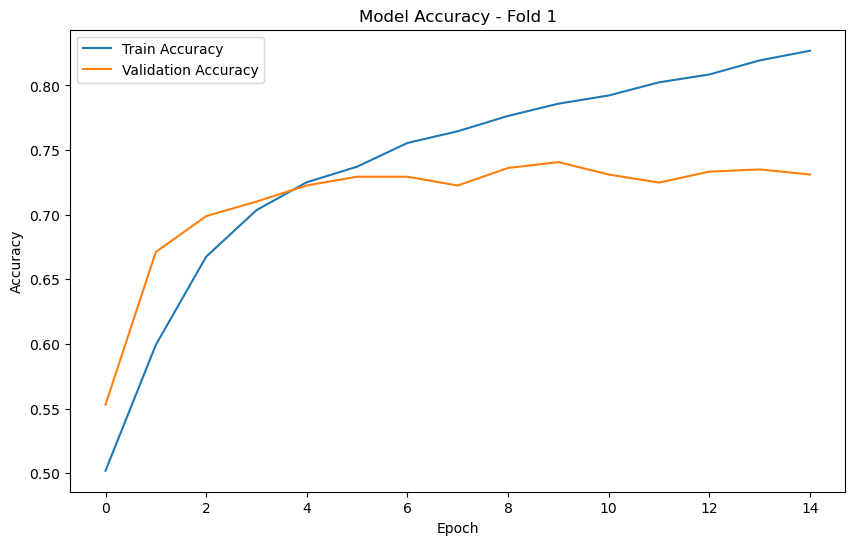

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7407
Balanced Accuracy: 0.7382
MCC: 0.4833
Sensitivity: 0.8160
Specificity: 0.6604

Learned track weights for fold 1:
Sequence weight: 0.6192
Structure weight: 0.3808

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.5150 - loss: 0.6961 - val_accuracy: 0.5740 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5719 - loss: 0.6745 - val_accuracy: 0.6667 - val_loss: 0.6078 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6877 - loss: 0.6030 - val_accuracy: 0.7124 - val_loss: 0.5592 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7202 - loss: 0.5613 - val_accuracy: 0.7401 - val_loss: 0.5292 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7373 - loss: 0.5376 - val_accuracy: 0.7486 - val_loss: 0.5161 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7458 - loss: 0.5253 - val_accuracy: 0.7492 - val_loss: 0.5084 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7562 - loss: 0.5067 - val

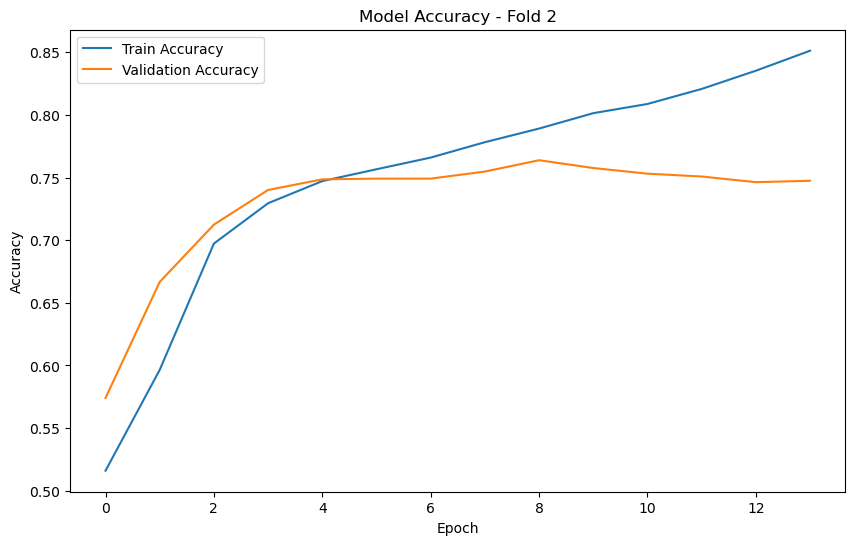

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7638
Balanced Accuracy: 0.7591
MCC: 0.5275
Sensitivity: 0.8419
Specificity: 0.6763

Learned track weights for fold 2:
Sequence weight: 0.5866
Structure weight: 0.4134

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4952 - loss: 0.6995 - val_accuracy: 0.5339 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5267 - loss: 0.6898 - val_accuracy: 0.5718 - val_loss: 0.6823 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5898 - loss: 0.6703 - val_accuracy: 0.6435 - val_loss: 0.6466 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6442 - loss: 0.6363 - val_accuracy: 0.6605 - val_loss: 0.6303 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6833 - loss: 0.6021 - val_accuracy: 0.6910 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7199 - loss: 0.5665 - val_accuracy: 0.7113 - val_loss: 0.5871 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7322 - loss: 0.5478 - val_

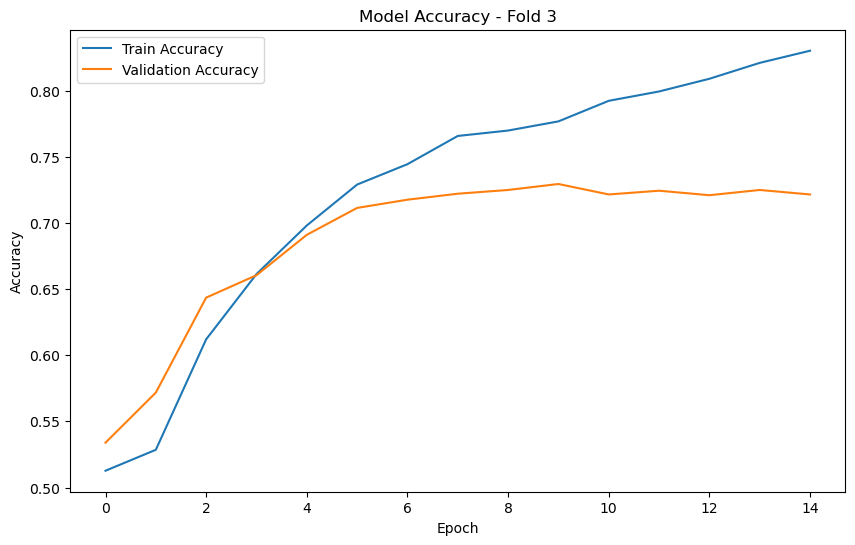

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7294
Balanced Accuracy: 0.7278
MCC: 0.4584
Sensitivity: 0.7788
Specificity: 0.6768

Learned track weights for fold 3:
Sequence weight: 0.5318
Structure weight: 0.4682

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5147 - loss: 0.6964 - val_accuracy: 0.5763 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5769 - loss: 0.6753 - val_accuracy: 0.6458 - val_loss: 0.6375 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6511 - loss: 0.6276 - val_accuracy: 0.6802 - val_loss: 0.6076 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6907 - loss: 0.5914 - val_accuracy: 0.7158 - val_loss: 0.5751 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7271 - loss: 0.5494 - val_accuracy: 0.7090 - val_loss: 0.5614 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7414 - loss: 0.5279 - val_accuracy: 0.7232 - val_loss: 0.5525 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7603 - loss: 0.5074 - val

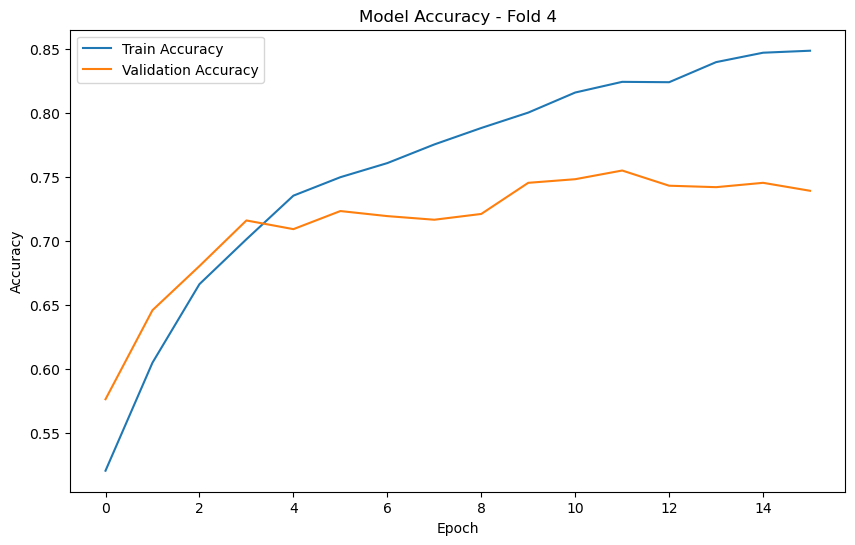

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7480
Balanced Accuracy: 0.7466
MCC: 0.4957
Sensitivity: 0.7919
Specificity: 0.7013

Learned track weights for fold 4:
Sequence weight: 0.6252
Structure weight: 0.3748

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5286 - loss: 0.6975 - val_accuracy: 0.5644 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5714 - loss: 0.6788 - val_accuracy: 0.6333 - val_loss: 0.6386 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6659 - loss: 0.6130 - val_accuracy: 0.6870 - val_loss: 0.5862 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7188 - loss: 0.5599 - val_accuracy: 0.7249 - val_loss: 0.5520 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7371 - loss: 0.5314 - val_accuracy: 0.7282 - val_loss: 0.5386 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7470 - loss: 0.5159 - val_accuracy: 0.7305 - val_loss: 0.5311 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7641 - loss: 0.4997 - val

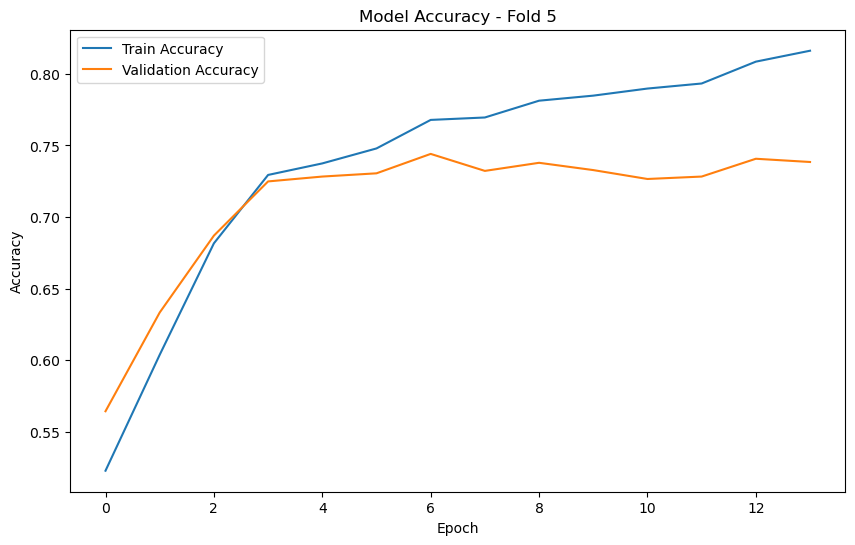

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7379
Balanced Accuracy: 0.7363
MCC: 0.4748
Sensitivity: 0.7786
Specificity: 0.6940

Learned track weights for fold 5:
Sequence weight: 0.6345
Structure weight: 0.3655

Average track weights across folds:
Sequence weight: 0.5995 ± 0.0375
Structure weight: 0.4005 ± 0.0375

Average Cross-validation Results:
ACC: 0.7440 ± 0.0116
BALANCED_ACC: 0.7416 ± 0.0106
MCC: 0.4879 ± 0.0232
SN: 0.8014 ± 0.0244
SP: 0.6818 ± 0.0144

Final Test Set Results:
Accuracy: 0.6916
Balanced Accuracy: 0.7368
MCC: 0.2792
Sensitivity: 0.7917
Specificity: 0.6820
Confusion Matrix:
[[1703  794]
 [  50  190]]


In [22]:
if __name__ == "__main__":
    model = train_and_evaluate()

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5143 - loss: 0.7014 - val_accuracy: 0.5740 - val_loss: 0.6812 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5871 - loss: 0.6703 - val_accuracy: 0.6780 - val_loss: 0.6267 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6577 - loss: 0.6227 - val_accuracy: 0.7203 - val_loss: 0.5710 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7099 - loss: 0.5594 - val_accuracy: 0.7452 - val_loss: 0.5281 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7404 - loss: 0.5317 - val_accuracy: 0.7503 - val_loss: 0.5207 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7498 - loss: 0.5186 - val_accuracy: 0.7452 - val_loss: 0.5197 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7675 - loss: 0.5003 - val

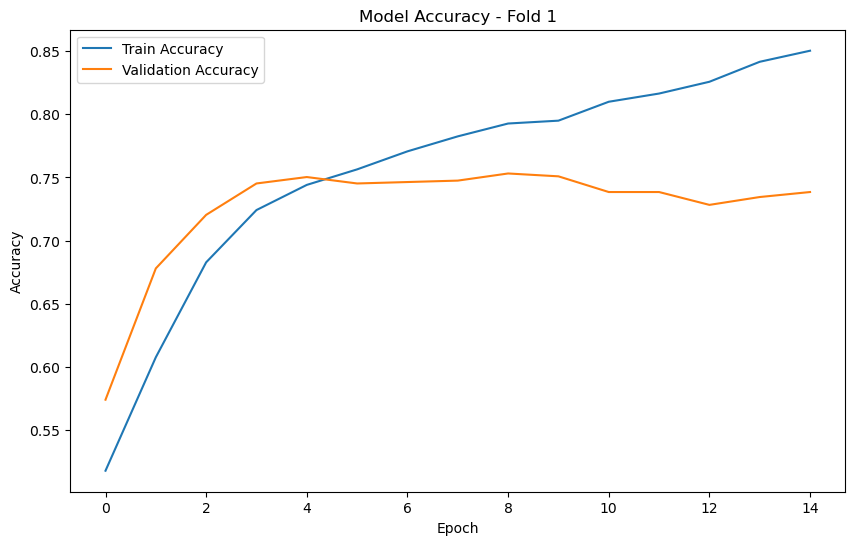

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7508
Balanced Accuracy: 0.7483
MCC: 0.5043
Sensitivity: 0.8291
Specificity: 0.6674

Learned track weights for fold 1:
Sequence weight: 0.5375
Structure weight: 0.4625

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5015 - loss: 0.6974 - val_accuracy: 0.5503 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5614 - loss: 0.6827 - val_accuracy: 0.5746 - val_loss: 0.6757 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5813 - loss: 0.6732 - val_accuracy: 0.6277 - val_loss: 0.6401 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6436 - loss: 0.6337 - val_accuracy: 0.7198 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7163 - loss: 0.5657 - val_accuracy: 0.7412 - val_loss: 0.5327 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7353 - loss: 0.5291 - val_accuracy: 0.7548 - val_loss: 0.5094 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7538 - loss: 0.5152 - val

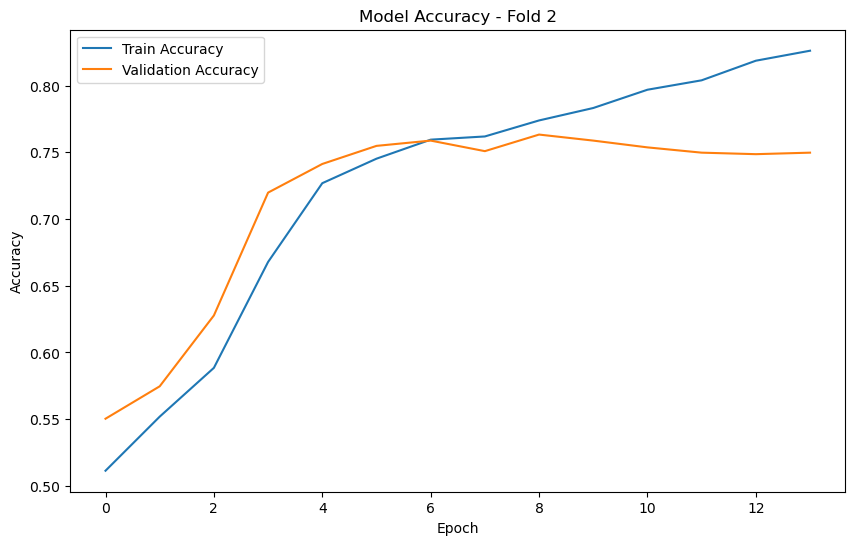

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7633
Balanced Accuracy: 0.7591
MCC: 0.5254
Sensitivity: 0.8312
Specificity: 0.6871

Learned track weights for fold 2:
Sequence weight: 0.5641
Structure weight: 0.4359

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5032 - loss: 0.7025 - val_accuracy: 0.5751 - val_loss: 0.6887 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5680 - loss: 0.6792 - val_accuracy: 0.6554 - val_loss: 0.6388 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6549 - loss: 0.6256 - val_accuracy: 0.6989 - val_loss: 0.5849 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7100 - loss: 0.5755 - val_accuracy: 0.7198 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7402 - loss: 0.5375 - val_accuracy: 0.7322 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7524 - loss: 0.5129 - val_accuracy: 0.7288 - val_loss: 0.5535 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7689 - loss: 0.4934 - val

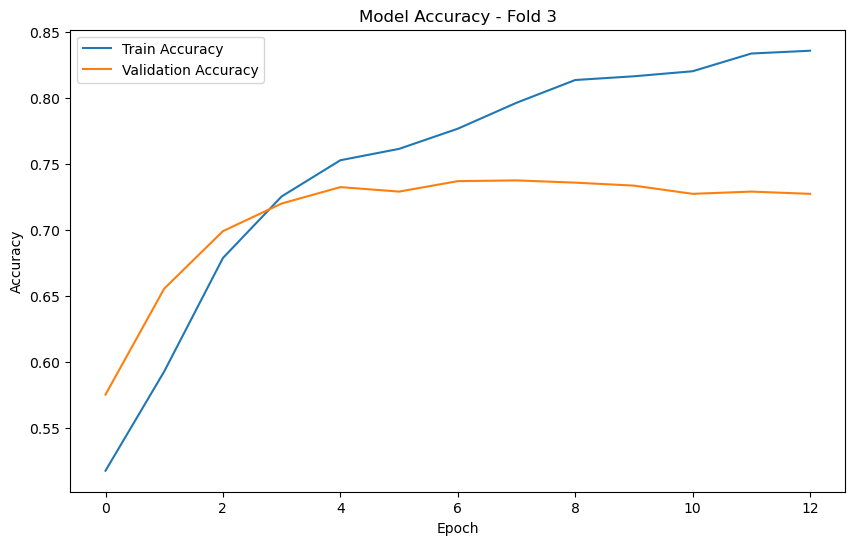

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7373
Balanced Accuracy: 0.7372
MCC: 0.4742
Sensitivity: 0.7404
Specificity: 0.7340

Learned track weights for fold 3:
Sequence weight: 0.5330
Structure weight: 0.4670

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5229 - loss: 0.6997 - val_accuracy: 0.5718 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5596 - loss: 0.6808 - val_accuracy: 0.6859 - val_loss: 0.6051 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6985 - loss: 0.5841 - val_accuracy: 0.7034 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7251 - loss: 0.5435 - val_accuracy: 0.7186 - val_loss: 0.5536 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7447 - loss: 0.5133 - val_accuracy: 0.7333 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7664 - loss: 0.4989 - val_accuracy: 0.7441 - val_loss: 0.5260 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7797 - loss: 0.4792 - val_

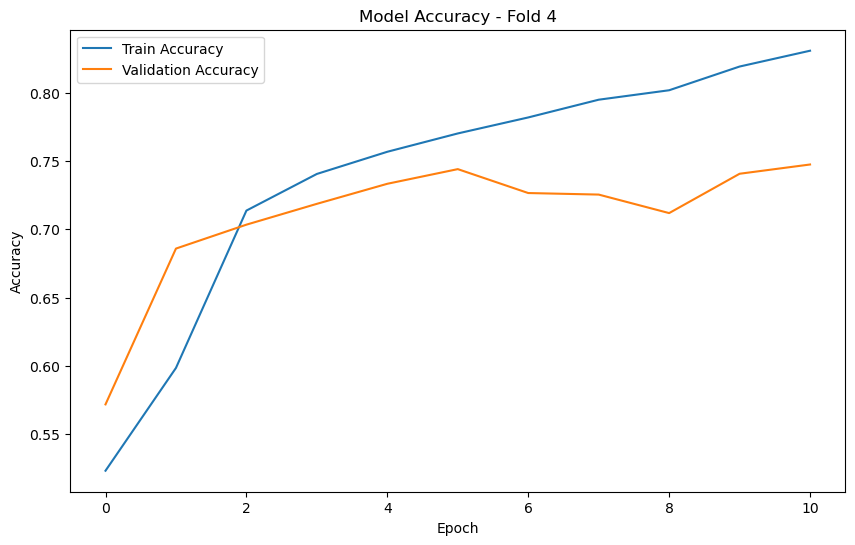

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7441
Balanced Accuracy: 0.7440
MCC: 0.4879
Sensitivity: 0.7448
Specificity: 0.7433

Learned track weights for fold 4:
Sequence weight: 0.5656
Structure weight: 0.4344

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5352 - loss: 0.6986 - val_accuracy: 0.6051 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6026 - loss: 0.6615 - val_accuracy: 0.6723 - val_loss: 0.6039 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7026 - loss: 0.5876 - val_accuracy: 0.7237 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7384 - loss: 0.5375 - val_accuracy: 0.7249 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7542 - loss: 0.5151 - val_accuracy: 0.7390 - val_loss: 0.5281 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7640 - loss: 0.5021 - val_accuracy: 0.7350 - val_loss: 0.5254 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7741 - loss: 0.4886 - val_

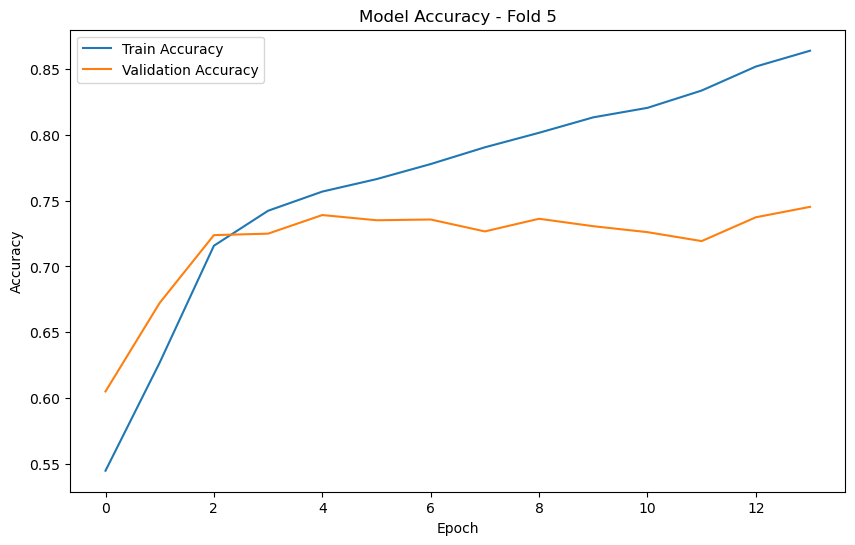

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7362
Balanced Accuracy: 0.7366
MCC: 0.4729
Sensitivity: 0.7241
Specificity: 0.7491

Learned track weights for fold 5:
Sequence weight: 0.5784
Structure weight: 0.4216

Average track weights across folds:
Sequence weight: 0.5557 ± 0.0175
Structure weight: 0.4443 ± 0.0175

Average Cross-validation Results:
ACC: 0.7463 ± 0.0100
BALANCED_ACC: 0.7451 ± 0.0083
MCC: 0.4930 ± 0.0198
SN: 0.7739 ± 0.0464
SP: 0.7162 ± 0.0327

Final Test Set Results:
Accuracy: 0.7139
Balanced Accuracy: 0.7415
MCC: 0.2896
Sensitivity: 0.7750
Specificity: 0.7080
Confusion Matrix:
[[1768  729]
 [  54  186]]


In [23]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=1)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5266 - loss: 0.6969 - val_accuracy: 0.5689 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5590 - loss: 0.6849 - val_accuracy: 0.5667 - val_loss: 0.6728 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5627 - loss: 0.6803 - val_accuracy: 0.5723 - val_loss: 0.6651 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5837 - loss: 0.6691 - val_accuracy: 0.6689 - val_loss: 0.6230 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6513 - loss: 0.6270 - val_accuracy: 0.7045 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7070 - loss: 0.5751 - val_accuracy: 0.7424 - val_loss: 0.5297 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7429 - loss: 0.5365 - val

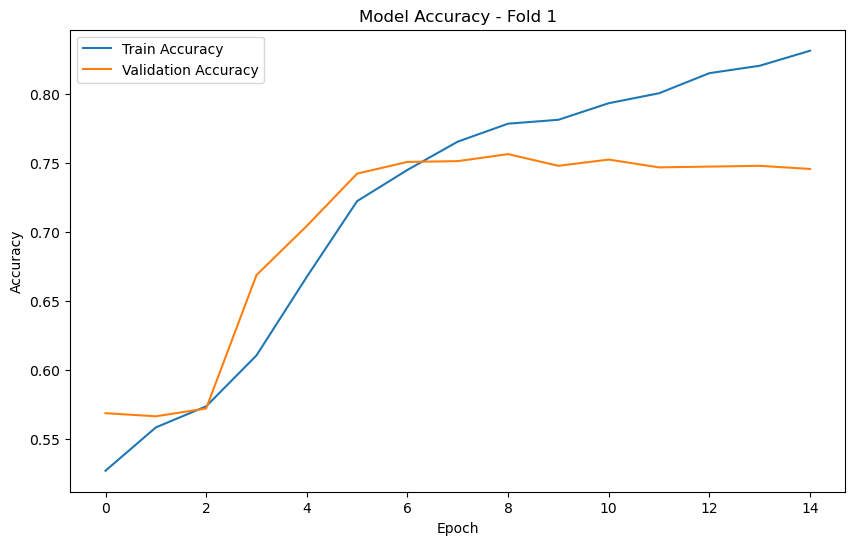

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7480
Balanced Accuracy: 0.7463
MCC: 0.4963
Sensitivity: 0.8018
Specificity: 0.6908

Learned track weights for fold 1:
Sequence weight: 0.4978
Structure weight: 0.5022

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.4868 - loss: 0.7177 - val_accuracy: 0.5486 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5538 - loss: 0.6873 - val_accuracy: 0.6458 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6559 - loss: 0.6254 - val_accuracy: 0.7158 - val_loss: 0.5581 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7265 - loss: 0.5633 - val_accuracy: 0.7475 - val_loss: 0.5259 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7393 - loss: 0.5345 - val_accuracy: 0.7390 - val_loss: 0.5219 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7497 - loss: 0.5182 - val_accuracy: 0.7463 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7651 - loss: 0.5059 - val

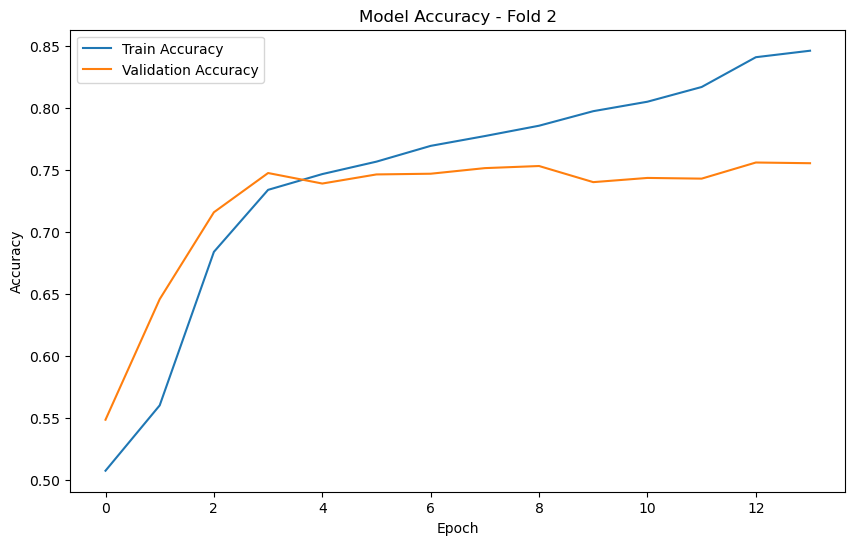

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7531
Balanced Accuracy: 0.7513
MCC: 0.5039
Sensitivity: 0.7831
Specificity: 0.7194

Learned track weights for fold 2:
Sequence weight: 0.5555
Structure weight: 0.4445

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5057 - loss: 0.7057 - val_accuracy: 0.6096 - val_loss: 0.6810 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6073 - loss: 0.6622 - val_accuracy: 0.6571 - val_loss: 0.6260 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6760 - loss: 0.6070 - val_accuracy: 0.6989 - val_loss: 0.5866 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7200 - loss: 0.5613 - val_accuracy: 0.7056 - val_loss: 0.5829 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7349 - loss: 0.5322 - val_accuracy: 0.7113 - val_loss: 0.5797 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7390 - loss: 0.5242 - val_accuracy: 0.7220 - val_loss: 0.5634 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7613 - loss: 0.5023 - val

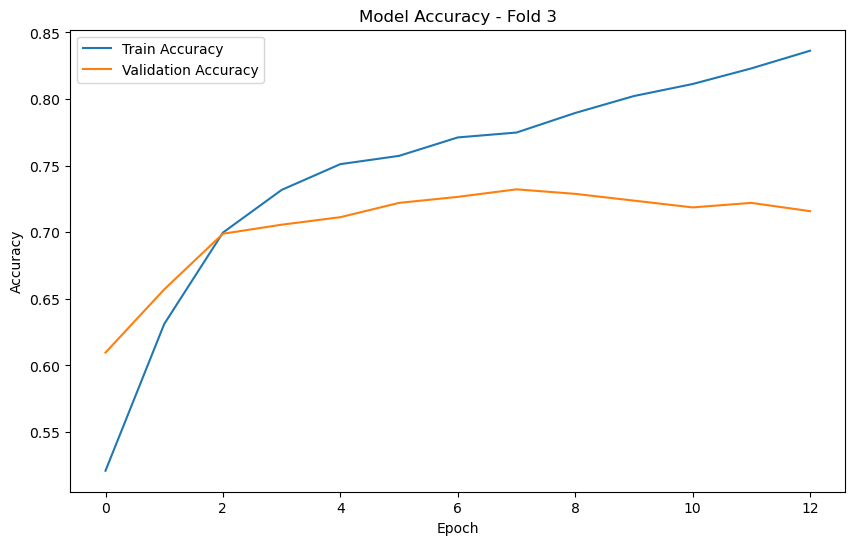

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7322
Balanced Accuracy: 0.7327
MCC: 0.4652
Sensitivity: 0.7174
Specificity: 0.7480

Learned track weights for fold 3:
Sequence weight: 0.5557
Structure weight: 0.4443

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5163 - loss: 0.6946 - val_accuracy: 0.5932 - val_loss: 0.6805 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5628 - loss: 0.6791 - val_accuracy: 0.5989 - val_loss: 0.6601 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6148 - loss: 0.6530 - val_accuracy: 0.6825 - val_loss: 0.6133 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6919 - loss: 0.5921 - val_accuracy: 0.7062 - val_loss: 0.5688 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7281 - loss: 0.5494 - val_accuracy: 0.7254 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7498 - loss: 0.5238 - val_accuracy: 0.7294 - val_loss: 0.5478 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7611 - loss: 0.5053 - val

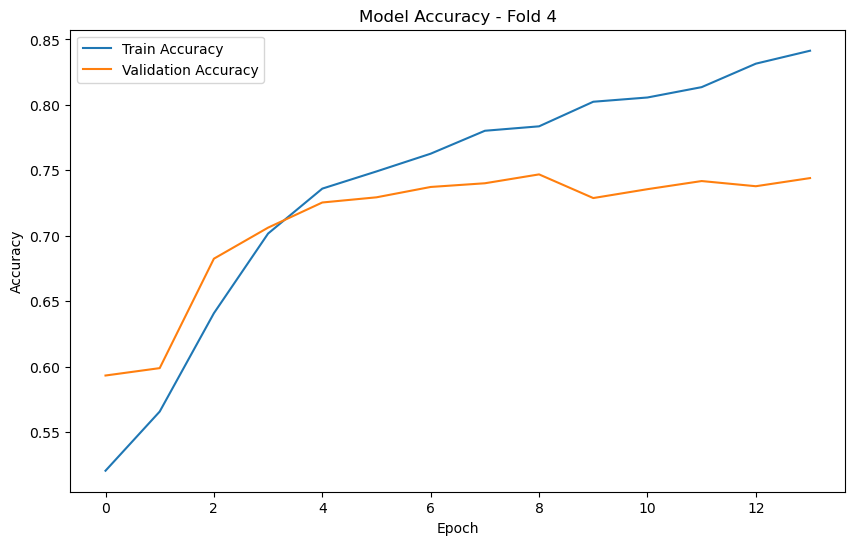

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 4 Results:
Accuracy: 0.7469
Balanced Accuracy: 0.7458
MCC: 0.4931
Sensitivity: 0.7798
Specificity: 0.7118

Learned track weights for fold 4:
Sequence weight: 0.5576
Structure weight: 0.4424

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.5261 - loss: 0.7023 - val_accuracy: 0.5718 - val_loss: 0.6864 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5876 - loss: 0.6746 - val_accuracy: 0.5847 - val_loss: 0.6781 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5917 - loss: 0.6668 - val_accuracy: 0.6028 - val_loss: 0.6616 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6310 - loss: 0.6427 - val_accuracy: 0.6362 - val_loss: 0.6365 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6614 - loss: 0.6173 - val_accuracy: 0.6605 - val_loss: 0.6144 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6945 - loss: 0.5925 - val_accuracy: 0.6910 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7237 - loss: 0.5602 - val

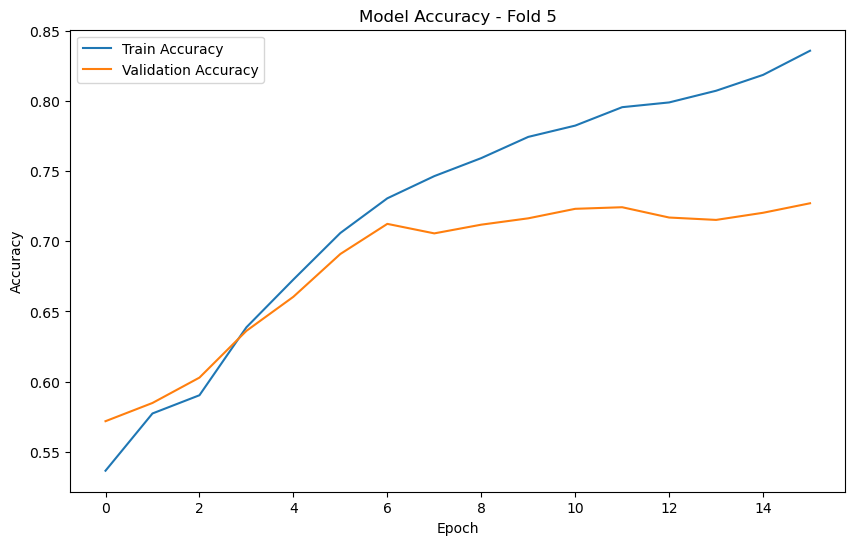

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7232
Balanced Accuracy: 0.7248
MCC: 0.4504
Sensitivity: 0.6805
Specificity: 0.7691

Learned track weights for fold 5:
Sequence weight: 0.5485
Structure weight: 0.4515

Average track weights across folds:
Sequence weight: 0.5430 ± 0.0228
Structure weight: 0.4570 ± 0.0228

Average Cross-validation Results:
ACC: 0.7407 ± 0.0112
BALANCED_ACC: 0.7402 ± 0.0099
MCC: 0.4818 ± 0.0204
SN: 0.7525 ± 0.0459
SP: 0.7278 ± 0.0276

Final Test Set Results:
Accuracy: 0.7355
Balanced Accuracy: 0.7590
MCC: 0.3154
Sensitivity: 0.7875
Specificity: 0.7305
Confusion Matrix:
[[1824  673]
 [  51  189]]


In [24]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=2)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5100 - loss: 0.6982 - val_accuracy: 0.5740 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5833 - loss: 0.6699 - val_accuracy: 0.7141 - val_loss: 0.5870 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7020 - loss: 0.5778 - val_accuracy: 0.7418 - val_loss: 0.5338 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7272 - loss: 0.5387 - val_accuracy: 0.7429 - val_loss: 0.5278 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7490 - loss: 0.5128 - val_accuracy: 0.7407 - val_loss: 0.5192 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7761 - loss: 0.4944 - val_accuracy: 0.7356 - val_loss: 0.5204 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7845 - loss: 0.4763 - val

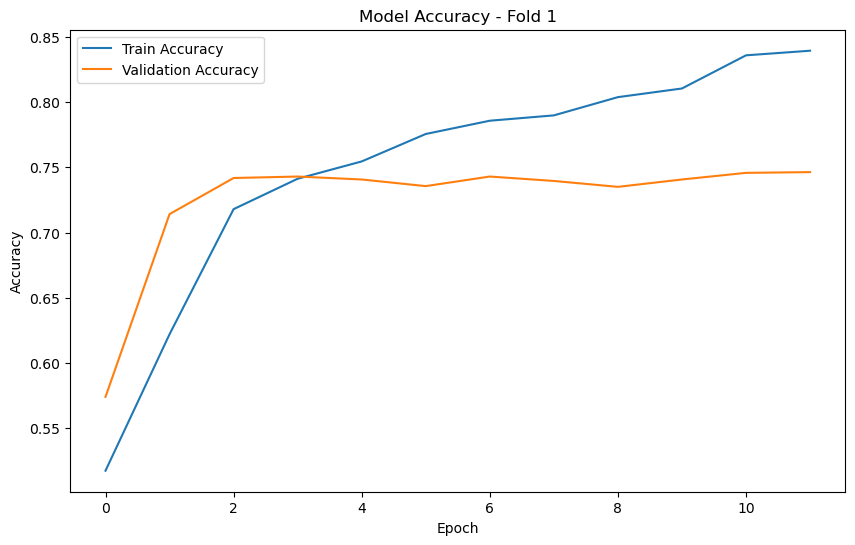

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7429
Balanced Accuracy: 0.7409
MCC: 0.4867
Sensitivity: 0.8061
Specificity: 0.6756

Learned track weights for fold 1:
Sequence weight: 0.5557
Structure weight: 0.4443

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5023 - loss: 0.7116 - val_accuracy: 0.5379 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5604 - loss: 0.6846 - val_accuracy: 0.6277 - val_loss: 0.6689 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6190 - loss: 0.6589 - val_accuracy: 0.6520 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6735 - loss: 0.6111 - val_accuracy: 0.6921 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7111 - loss: 0.5669 - val_accuracy: 0.7508 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7393 - loss: 0.5368 - val_accuracy: 0.7599 - val_loss: 0.5229 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7500 - loss: 0.5186 - val

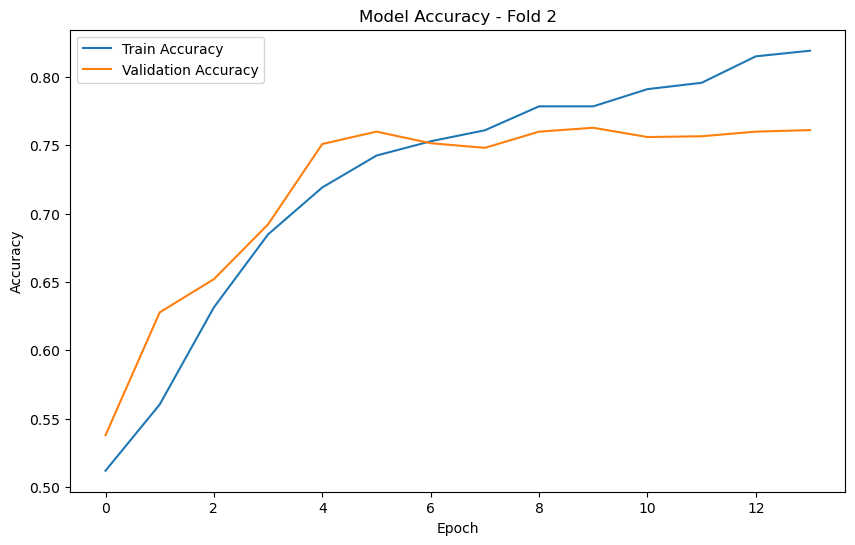

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7599
Balanced Accuracy: 0.7581
MCC: 0.5175
Sensitivity: 0.7895
Specificity: 0.7266

Learned track weights for fold 2:
Sequence weight: 0.5552
Structure weight: 0.4448

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5110 - loss: 0.7076 - val_accuracy: 0.5633 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5858 - loss: 0.6734 - val_accuracy: 0.6243 - val_loss: 0.6414 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6807 - loss: 0.6030 - val_accuracy: 0.7130 - val_loss: 0.5623 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7263 - loss: 0.5537 - val_accuracy: 0.7232 - val_loss: 0.5518 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7443 - loss: 0.5244 - val_accuracy: 0.7288 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7548 - loss: 0.5150 - val_accuracy: 0.7345 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7753 - loss: 0.4859 - val

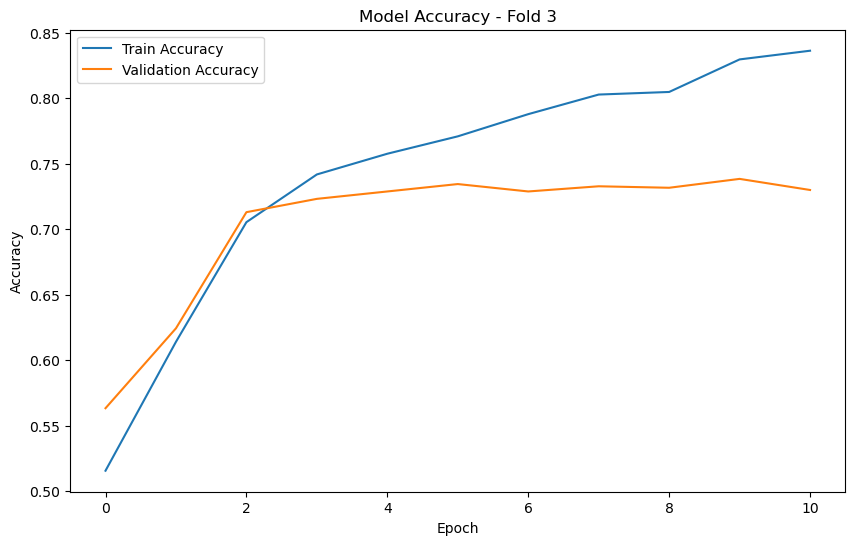

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7345
Balanced Accuracy: 0.7357
MCC: 0.4721
Sensitivity: 0.6966
Specificity: 0.7748

Learned track weights for fold 3:
Sequence weight: 0.5641
Structure weight: 0.4359

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5210 - loss: 0.6993 - val_accuracy: 0.6158 - val_loss: 0.6763 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6056 - loss: 0.6632 - val_accuracy: 0.6531 - val_loss: 0.6262 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6639 - loss: 0.6105 - val_accuracy: 0.6960 - val_loss: 0.5909 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7174 - loss: 0.5659 - val_accuracy: 0.6836 - val_loss: 0.5844 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7435 - loss: 0.5350 - val_accuracy: 0.7028 - val_loss: 0.5630 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7597 - loss: 0.5114 - val_accuracy: 0.7271 - val_loss: 0.5388 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7738 - loss: 0.4901 - val

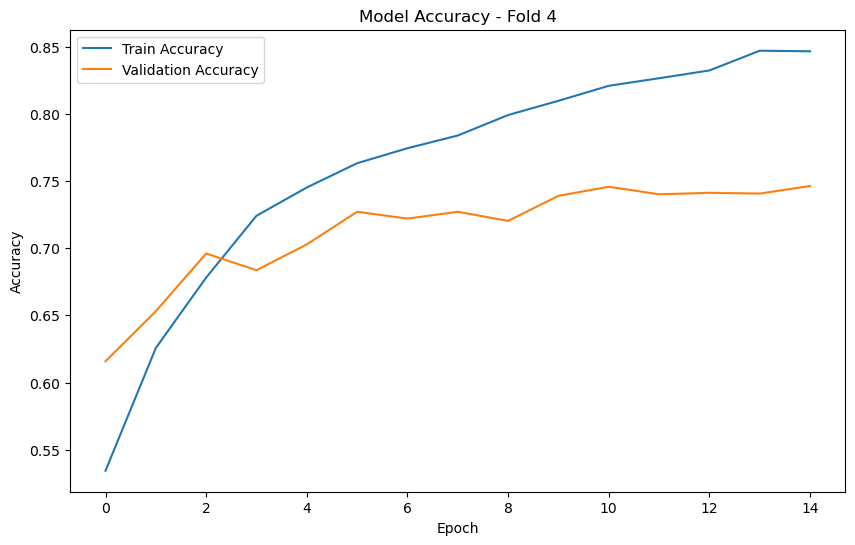

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7390
Balanced Accuracy: 0.7360
MCC: 0.4817
Sensitivity: 0.8291
Specificity: 0.6429

Learned track weights for fold 4:
Sequence weight: 0.5374
Structure weight: 0.4626

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5232 - loss: 0.6942 - val_accuracy: 0.5740 - val_loss: 0.6841 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5652 - loss: 0.6742 - val_accuracy: 0.6644 - val_loss: 0.6170 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6835 - loss: 0.6040 - val_accuracy: 0.7107 - val_loss: 0.5544 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7306 - loss: 0.5463 - val_accuracy: 0.7215 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7528 - loss: 0.5196 - val_accuracy: 0.7271 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7594 - loss: 0.5059 - val_accuracy: 0.7288 - val_loss: 0.5360 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7707 - loss: 0.4963 - val_

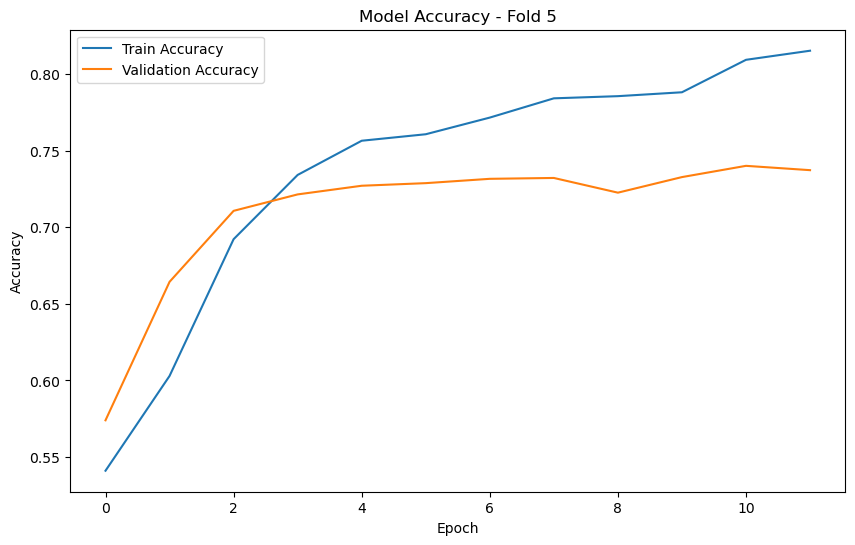

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7316
Balanced Accuracy: 0.7318
MCC: 0.4633
Sensitivity: 0.7274
Specificity: 0.7362

Learned track weights for fold 5:
Sequence weight: 0.5662
Structure weight: 0.4338

Average track weights across folds:
Sequence weight: 0.5557 ± 0.0101
Structure weight: 0.4443 ± 0.0101

Average Cross-validation Results:
ACC: 0.7416 ± 0.0099
BALANCED_ACC: 0.7405 ± 0.0092
MCC: 0.4843 ± 0.0185
SN: 0.7698 ± 0.0498
SP: 0.7112 ± 0.0465

Final Test Set Results:
Accuracy: 0.7147
Balanced Accuracy: 0.7400
MCC: 0.2882
Sensitivity: 0.7708
Specificity: 0.7093
Confusion Matrix:
[[1771  726]
 [  55  185]]


In [25]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=3)